# An illustration of the MARBLE method on the FitzHugh-Nagumo model

In [5]:
#!/usr/bin/env python3
# FHN_MARBLE_demo.py - Simplified FitzHugh-Nagumo model analyzed with MARBLE
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch

import MARBLE
from MARBLE import plotting, geometry
import MARBLE.preprocessing as mprep
import MARBLE.dynamics as dynamics

def get_pos_vel(n_trajectories,params, t, area, alpha=0.05):
    X0_range = dynamics.initial_conditions(n_trajectories, len(params), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, params):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))

    pos, vel = dynamics.embed_parabola(pos, vel, alpha=alpha)
    return pos, vel

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# Default FHN model parameters
FHN_PARAMS = {
    "a": 0.7,
    "b": 0.8,
    "tau": 12.5,
    "I_ext": 0.5
}

# MARBLE parameters
MARBLE_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'lr': 0.01,
    'momentum': 0.9,
    'diffusion': True,
    'hidden_channels': [64, 32],
    'out_channels': 5,
    'batch_norm': True,
    'seed': 42
}

print("Simplified FitzHugh-Nagumo MARBLE Demo")
print("=" * 40)

# Setup
n_trajectories = 100  # Number of trajectories to simulate
ntime = 100
t_span = np.linspace(0, 10, ntime)  # Time points
area = [[-2.0, -4.], [2.0, .0]]

# Parameter to vary (set to None for fixed parameters)
vary_param = 'b'
param_range = [1.25, 1.8]
n_params = 50
params = np.linspace(param_range[0], param_range[1], n_params)

print(f"Generating {n_trajectories} trajectories...")

os.makedirs(f'temp_Figures/fhn_{vary_param}', exist_ok=True)
os.makedirs(f'temp_Data/fhn_{vary_param}', exist_ok=True)

pos_list,vel_list = get_pos_vel(n_trajectories,params, t_span, area,alpha=0.05)

# Plot phase space trajectories for 5 sampled parameters
plt.figure(figsize=(10, 8))
scatter = None

# Sample 5 evenly spaced parameter indices
sample_indices = np.linspace(0, n_params-1, 10, dtype=int)
colors = plt.cm.viridis(np.linspace(0, 1, 10))

for idx, param_idx in enumerate(sample_indices):
    scatter = plt.scatter(pos_list[param_idx][:, 0], pos_list[param_idx][:, 1],
                         c=colors[idx], alpha=0.7, s=1)
plt.colorbar()
plt.title('FHN Phase Space Trajectories for Selected Parameter Values')
plt.xlabel('Voltage (x)')
plt.ylabel('Recovery (y)')
plt.legend()
plt.savefig(f'temp_Figures/fhn_{vary_param}/phase_space_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot time series for variable x
plt.figure(figsize=(12, 6))
for idx, param_idx in enumerate(sample_indices[:]):
    x_timeseries = pos_list[param_idx][:, 0]  # Extract x variable
    plt.plot(t_span, x_timeseries[param_idx*ntime:(param_idx+1)*ntime], color=colors[idx], 
             label=f'{vary_param}={params[param_idx]:.2f}')

plt.title('Time Series of Voltage Variable (x) for Different Parameter Values')
plt.xlabel('Time')
plt.ylabel('Voltage (x)')
plt.legend()
plt.savefig(f'temp_Figures/fhn_{vary_param}/voltage_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

Simplified FitzHugh-Nagumo MARBLE Demo
Generating 100 trajectories...


KeyboardInterrupt: 

/home/honglab/leijiaxin/MARBLE/fhn_phase_plane_utils.py:101: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(fixed_point_eqs, guess)
/home/honglab/leijiaxin/MARBLE/fhn_phase_plane_utils.py:101: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sol = fsolve(fixed_point_eqs, guess)


Tracking limit cycles for 60 parameter values using -1 processes...
Found 8 limit cycle points in 258.53 seconds
Processing 8 limit cycle data points for plotting


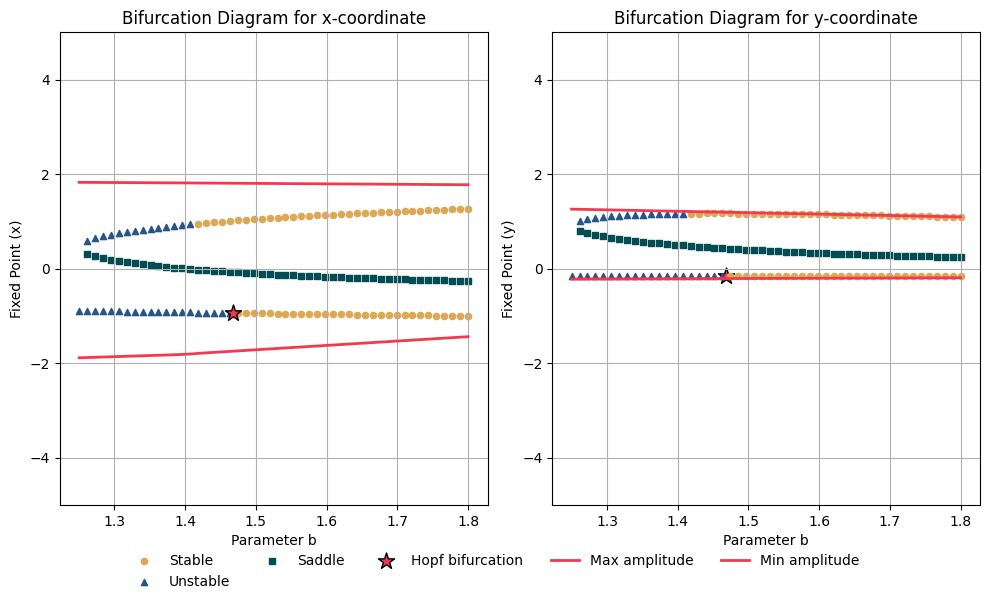

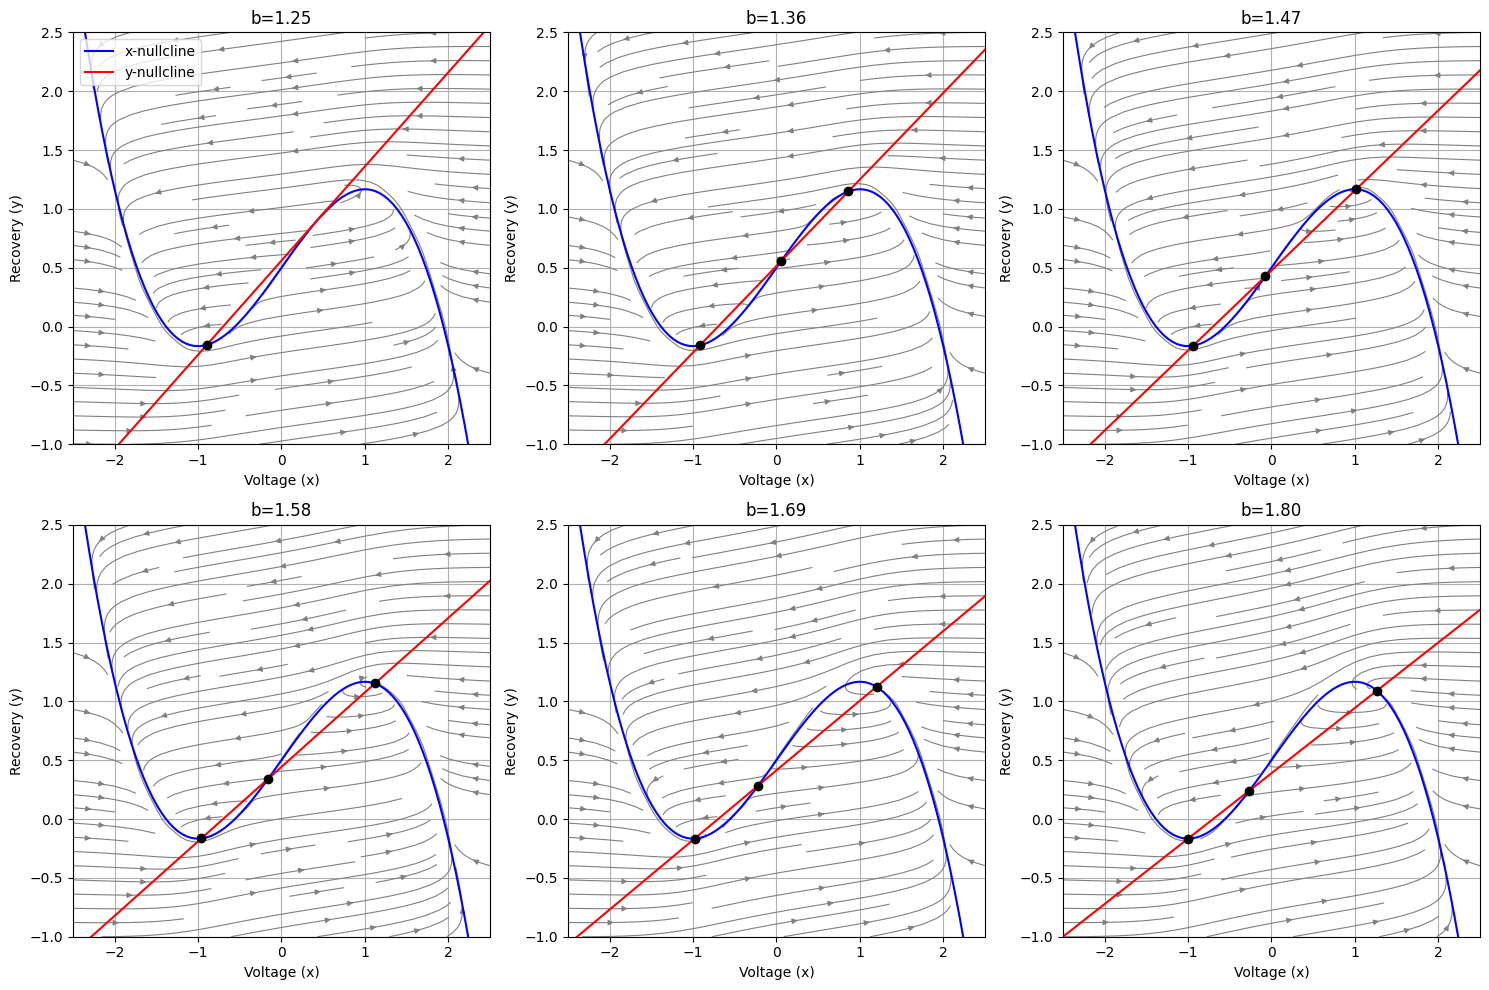

In [ ]:
# Create bifurcation plot using the utility function
from fhn_phase_plane_utils import *

# Setup other parameters (all parameters except the one we're varying)
other_params = FHN_PARAMS.copy()
del other_params[vary_param]  # Remove the parameter we're varying

# Call the bifurcation diagram function
fig, axes = plot_bifurcation_diagram(
    param_name=vary_param,
    param_range=param_range,
    other_params=other_params,
    num_points=n_params,
    figsize=(10, 6),
    y_lim=[-5, 5],
    n_jobs= -1,
)

# Save the bifurcation diagram
plt.savefig(f'temp_Figures/fhn_{vary_param}/bifurcation_diagram_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

# Create phase plane plots for different parameter values
param_values = np.linspace(param_range[0], param_range[1], 6)  # Sample 6 values
fig = parameter_sweep_phase_planes(
    param_name=vary_param,
    param_values=param_values,
    other_params=other_params,
    x_range=[-2.5, 2.5],
    y_range=[-1.0, 2.5],
    figsize=(15, 10)
)

# Save the phase plane plots
plt.savefig(f'temp_Figures/fhn_{vary_param}/phase_planes_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

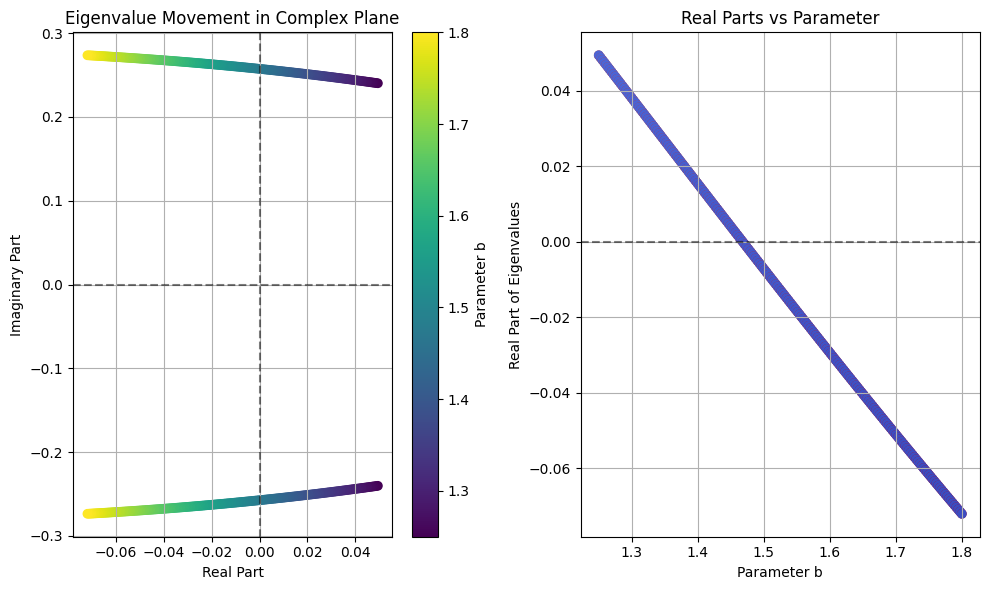

In [4]:
# Example usage - track eigenvalues for a point near b=1.2
point_near_transition = [1.0, 0.0]  # Starting point to track (x,y)
fig, axes = plot_eigenvalue_movement(vary_param,param_range, point_near_transition, FHN_PARAMS)
# Save the eigenvalue movement plot
plt.savefig(f'temp_Figures/fhn_{vary_param}/eigenvalue_movement_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
load_dataset = True 
load_model = True
save_path = f'temp_Data/fhn_{vary_param}/fhn_dataset_{vary_param}.pkl'
model_path = f'temp_Data/fhn_{vary_param}/fhn_model_{vary_param}.pkl'

# Prepare dataset and train model
if not load_dataset:
    data = MARBLE.construct_dataset(anchor=pos_list, vector=vel_list, spacing=0.03)
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Dataset saved to {save_path}")
else:
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Dataset loaded from {save_path}")

model = MARBLE.net(data, params=MARBLE_PARAMS)

if not load_model:
    model.fit(data, outdir='temp_Data')
    # Save the trained model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")
else:
    # Load the trained model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {model_path}")

# Transform data and calculate distances
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)

FileNotFoundError: [Errno 2] No such file or directory: 'temp_Data/fhn_b/fhn_dataset_b.pkl'

In [4]:
# Visualize embeddings
plt.figure(figsize=(4, 4))
ax = plotting.embedding(data, params[data.y.numpy().astype(int)])

plt.savefig(f'temp_Figures/fhn_{vary_param}/embedding_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()
# Plot distance matrix
plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(data.dist, extent=[params[0], params[-1], params[-1], params[0]])
plt.colorbar(im)
plt.title('Distance Matrix')
plt.xlabel('Parameter Value')
plt.ylabel('Parameter Value')
plt.tight_layout()
plt.savefig(f'temp_Figures/fhn_distances_{vary_param}.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot different embeddings
embed_types = ['PCA', 'tsne', 'umap', 'Isomap', 'MDS']

for embed_typ in embed_types:
    emb, _ = geometry.embed(data.dist, embed_typ=embed_typ)
    plt.figure(figsize=(4, 4))
    ax = plotting.embedding(emb, params, s=30, alpha=1)
    plt.title(f'{embed_typ} Embedding')
    plt.savefig(f'temp_Figures/fhn_{vary_param}/{embed_typ.lower()}_{vary_param}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("=" * 40)
print("Demo completed. Results saved to temp_Figures/ directory.")

NameError: name 'data' is not defined

<Figure size 400x400 with 0 Axes>